# Data Explorations

The objective of this project is to build a model that can predict the prices of houses in the dataset. The dataset includes 79 variables and 1460 observations in both the test and train dataset. The variable we're trying to predict is "SalePrice."

In [296]:
import os
import pandas as pd
import numpy as np
from keras import optimizers
from subprocess import check_output
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
import matplotlib.pyplot as plt

Uploading and exploring the data.

In [297]:
os.getcwd()

'/Users/sauce/Desktop'

In [298]:
os.chdir('/Users/Sauce/Desktop')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [299]:
# Look at the data.

train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


We need to remove the I.D. variables but save them for later.

In [300]:
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Next we need to combine both the test and train data so we can perform the necessary data cleaning on all the data at once.. We'll save the saleprice values for later in a variables called "sales".

In [301]:
ntrain = train.shape[0]
ntest = test.shape[0]
sales = train.SalePrice.values

both = pd.concat((train, test)).reset_index(drop=True)
both.drop(['SalePrice'], axis=1, inplace=True)
print("Both size is : {}".format(both.shape))
Both size is : (2919, 79)

Both size is : (2919, 79)


Let's look at how SalePrice, the variable we're trying to predict, is related to other variables in the dataframe. Lighter colors indicated stronger coorilations.

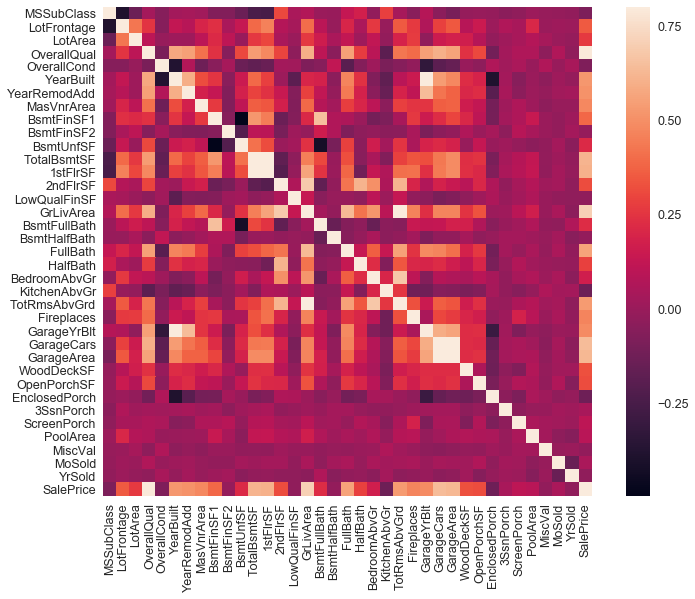

In [302]:
corrmatrix = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, vmax=.8, square=True);

Next we can check for the top 10 coorilated numeric variables to "SalePrice".

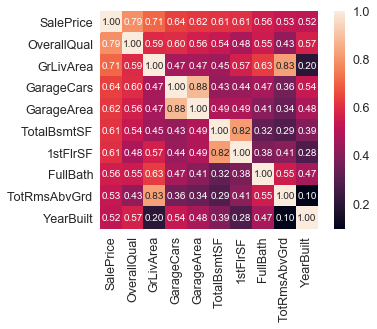

In [303]:
k = 10 #number of variables for heatmap
cols = corrmatrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The variables listed below SalePrice on the y-axis are the top 9 coorilations to 'SalePrice'. Let's visualize a few of these relationships. I chose to visualize the variables in Tableau, so the Code below won't work in python. First is the Sale Price Distribution. As we can see, it's skewed right, which makes sense because there aren't as many folks who can afford expensive houses. We might consider normalizing this variable before building our model.

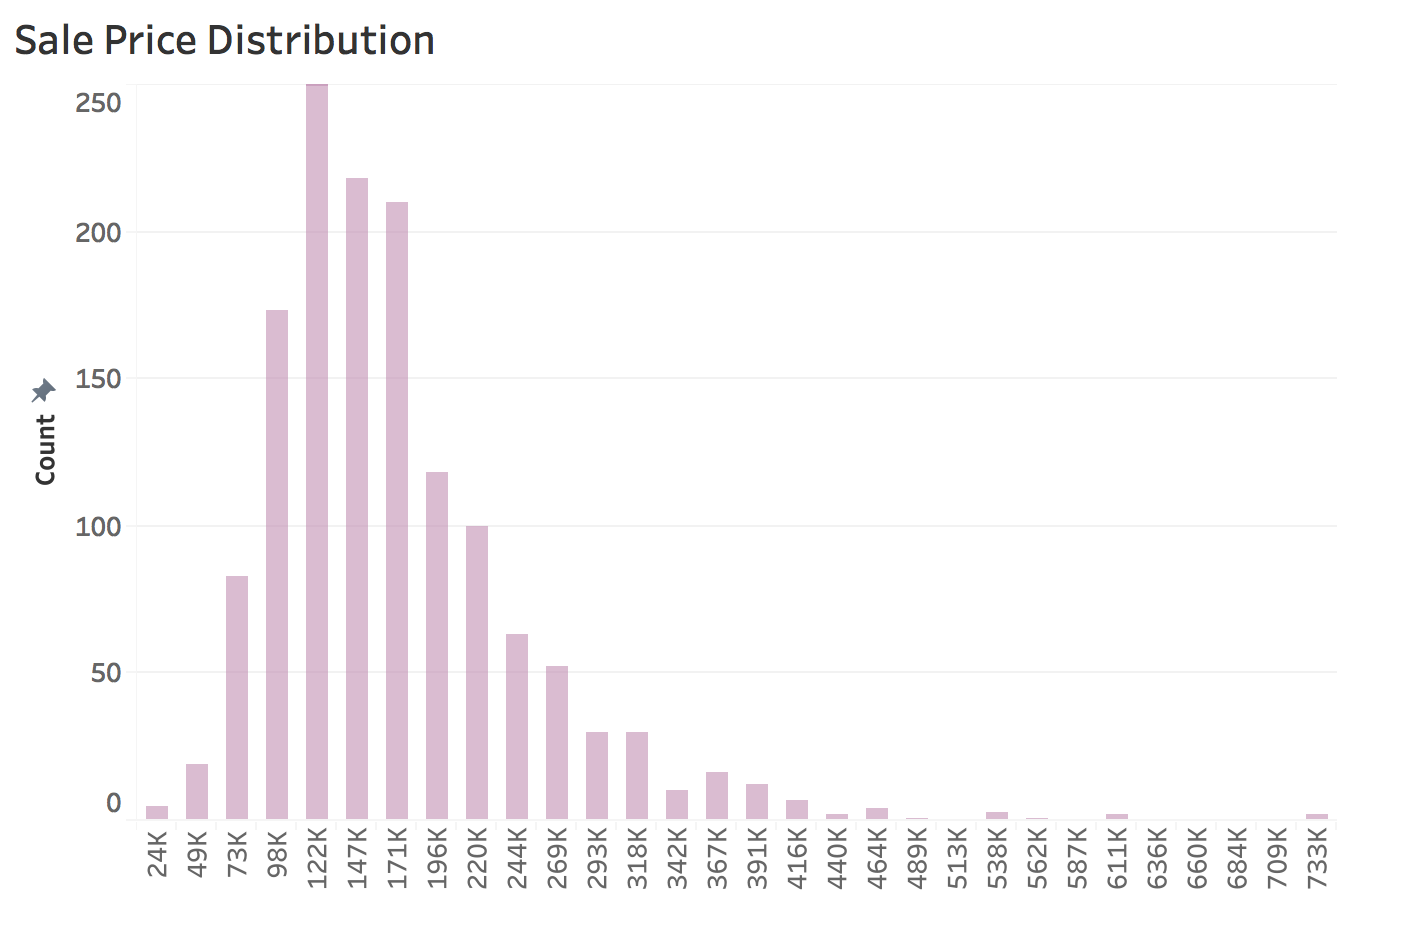

In [304]:
from IPython.display import Image
Image(filename="SPdist.png", width=600, height = 600)

The variable with the strongest coorelation is the Overall Quality variable. The visualization below shows how SalesPrice and Overall Quality are related.

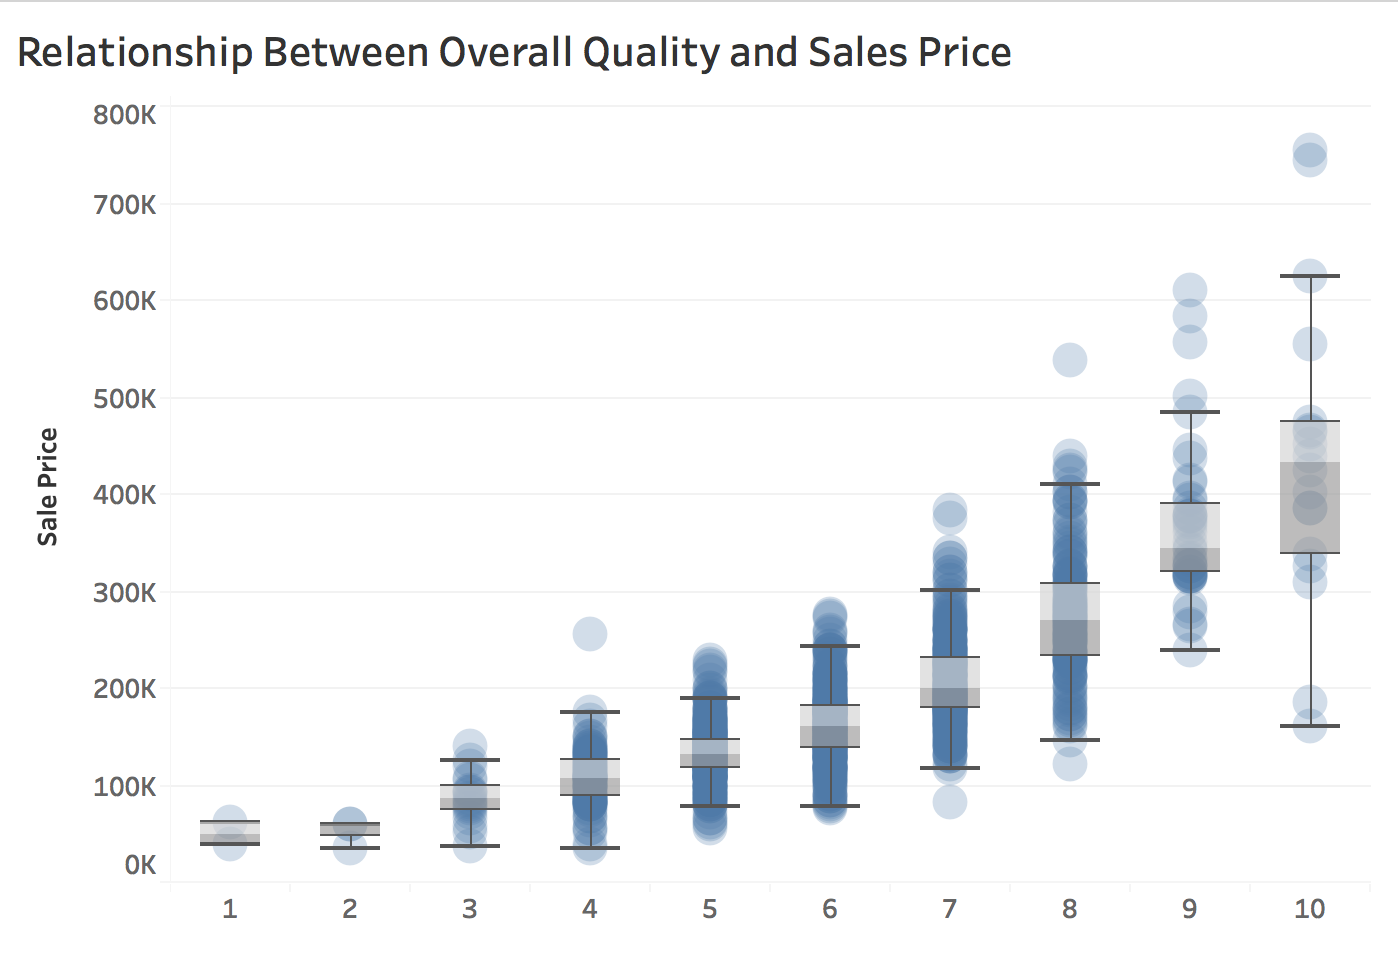

In [305]:
from IPython.display import Image
Image(filename="OverQ.png", width=600, height = 600)

The variable with the next highest correlation with SalePrice is "GrLiveArea", the living area of the house.

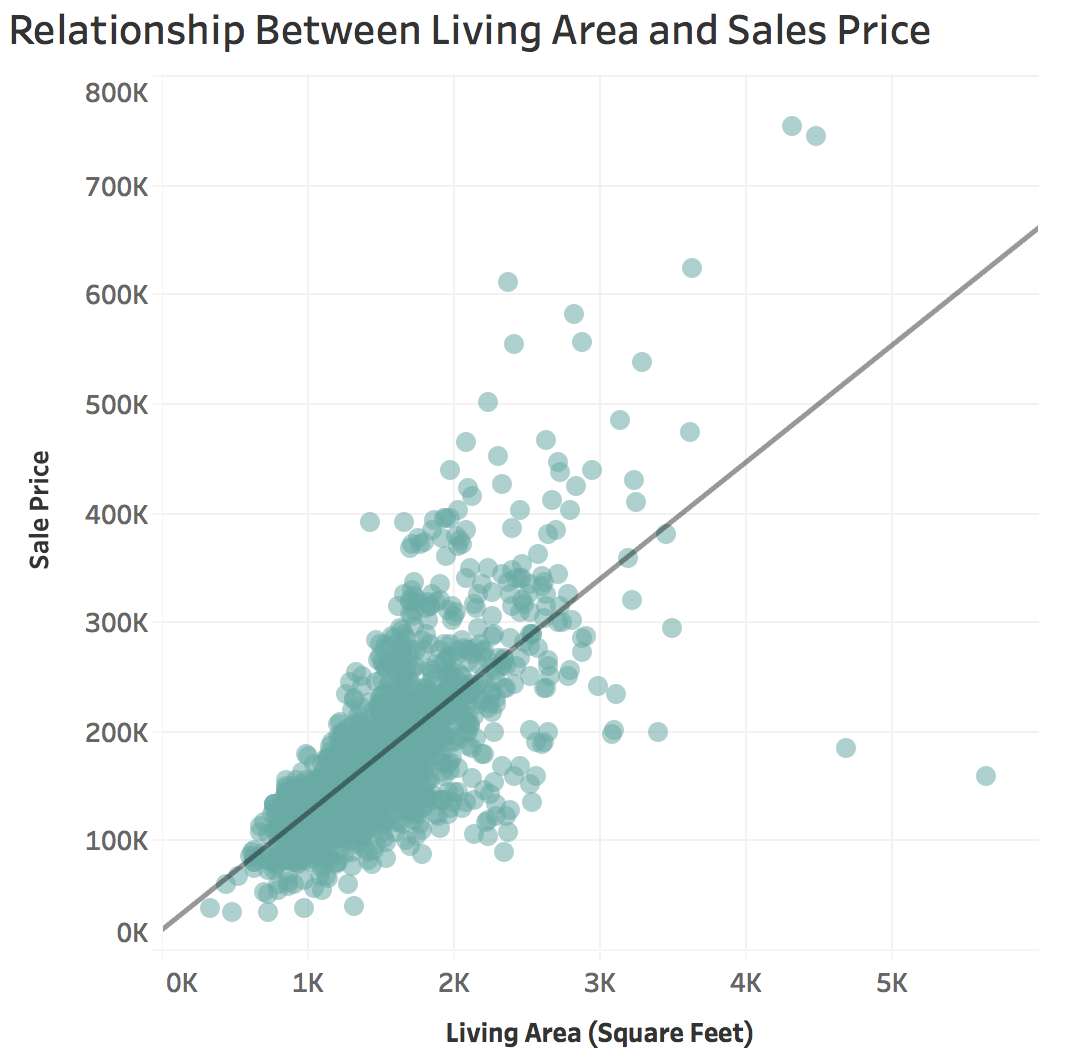

In [306]:
from IPython.display import Image
Image(filename="Live.png", width=600, height = 600)

An important categorical variable for determining the price of a house is the neighborhood of which the house is located.

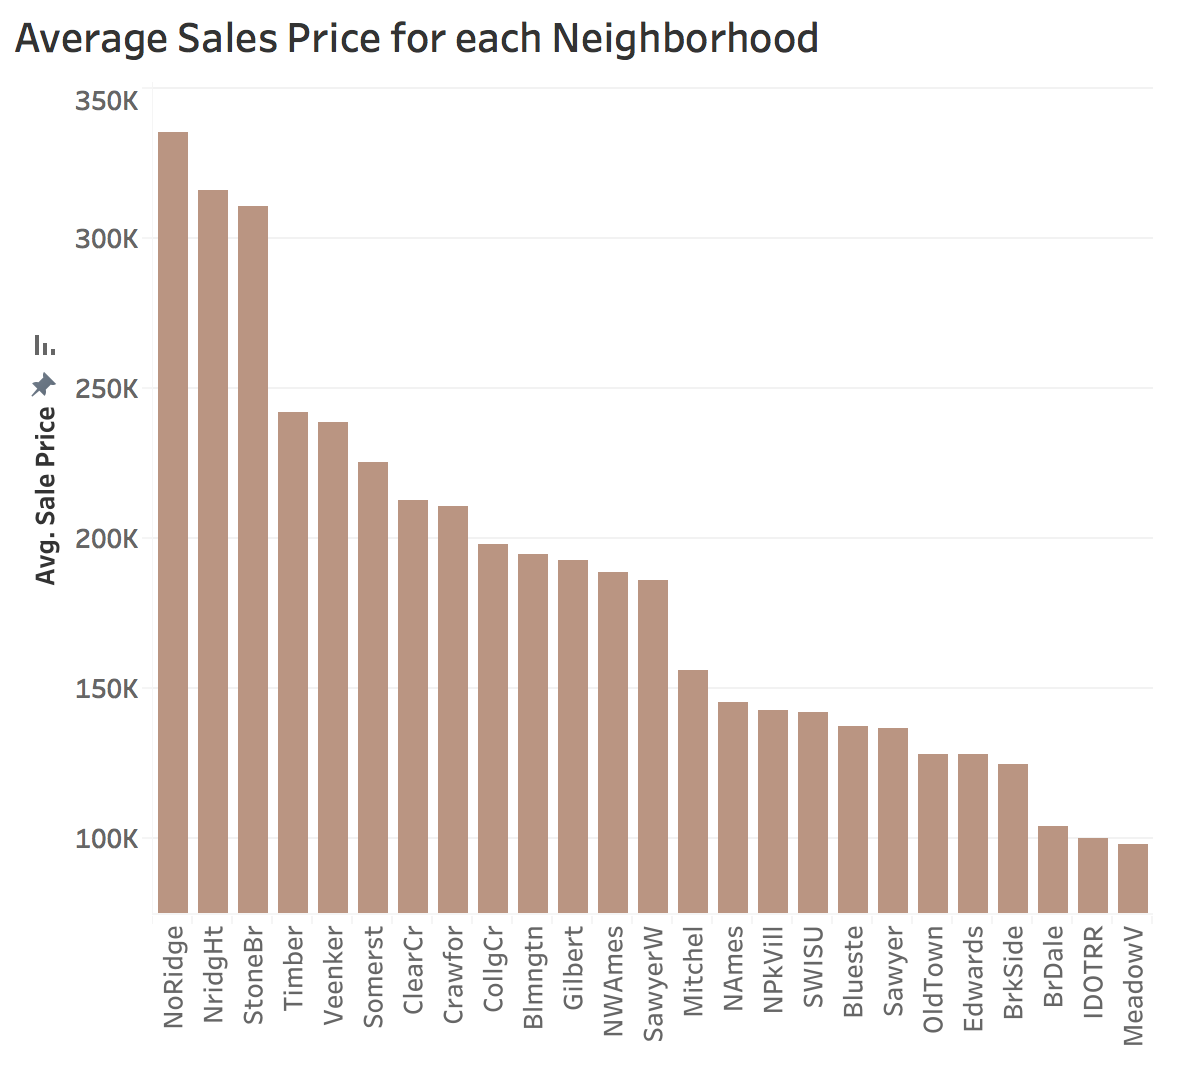

In [307]:
from IPython.display import Image
Image(filename="neigh.png", width=600, height = 600)

As shown above, the neighborhood for which the house is located is instrumental in determining the price of the house.

# Missing Data

We must go through the dataset and remove all missing data so the model can run effectively. This is by far the most tedious and time consuming step, but it's crucial to do this well to maintain the integrity of the data. If you get bored with the missing data section, feel free to skip ahead to "Feature Engineering".

In [308]:
both.columns[both.isnull().any()]

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SaleType', 'TotalBsmtSF', 'Utilities'],
      dtype='object')

As shown above, there are a lot of variables with missing data. We'll knock them out one by one.

### MSZoning
Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [309]:
print(both["MSZoning"].isnull().sum())
print(both['MSZoning'].value_counts())

4
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64


There are only 4 missing values in this dataset. The overwhelming mode of the dataset is "RL". We'll replace all missing values with RL.

In [310]:
both["MSZoning"] = both["MSZoning"].fillna("RL")

### Lot Frontage

Linear feet of street connected to property

In [311]:
print(both["LotFrontage"].isnull().sum())

486


486 "na" varibales is a lot of missing data. The other concern is the possiblity that the people recording this data didn't record any data for instances with no road connected to the street. We don't know if these values should be replaced by the median or with 0. For this reason, I think it best to remove this variable.

In [312]:
both = both.drop('LotFrontage', 1)

### Alley

Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
       
We'll replace "NA" with "None" for no alley access.

In [313]:
both["Alley"] = both["Alley"].fillna("None")

### Utilities

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [314]:
print(both["Utilities"].isnull().sum())
print(both['Utilities'].value_counts())

2
AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64


All records are "AllPub" except for 2 NAs and 1 "NoSewa". This variable won't help the model, so we'll remove it.

In [315]:
both = both.drop('Utilities', 1)

### Exterior1st and Exterior2nd

Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [316]:
print(both["Exterior1st"].isnull().sum())
print(both['Exterior1st'].value_counts())
print(both["Exterior2nd"].isnull().sum())

1
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
CBlock        2
AsphShn       2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64
1


Only one missing value for each, we'll replace with the mode of each variable.

In [317]:
both['Exterior1st'] = both['Exterior1st'].fillna(both['Exterior1st'].mode()[0])
both['Exterior2nd'] = both['Exterior2nd'].fillna(both['Exterior2nd'].mode()[0])

### MasVnrArea and MasVnrType

In [318]:
print(both["MasVnrArea"].isnull().sum())
print(both["MasVnrType"].isnull().sum())

23
24


23 and 24 NAs respectively. This might be somewhat
reckless, but I think it's safe enough to assume that
NAs represent no masronry. We'll replace the area with 0
and the Type with "None". Hopefully data recorders just
didn't fill in values when they didnt see any masonry.

In [319]:
both["MasVnrType"] = both["MasVnrType"].fillna("None")
both["MasVnrArea"] = both["MasVnrArea"].fillna(0)

### Numeric Basement Variables
'''BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath'''

In [320]:
print(both["BsmtFinSF1"].isnull().sum())
print(both["BsmtFinSF2"].isnull().sum())
print(both["BsmtUnfSF"].isnull().sum())
print(both["TotalBsmtSF"].isnull().sum())
print(both["BsmtFullBath"].isnull().sum())
print(both["BsmtHalfBath"].isnull().sum())

1
1
1
1
2
2


There are only 1 or 2 NAs for each variable.
We can assume that each NA means "no basement". We'll
replace each with 0.

In [321]:
for x in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    both[x] = both[x].fillna(0)

### Categorical Basement Variables.
'''BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2'''

In [322]:
print(both["BsmtQual"].isnull().sum())
print(both["BsmtCond"].isnull().sum())
print(both["BsmtExposure"].isnull().sum())
print(both["BsmtFinType1"].isnull().sum())
print(both["BsmtFinType2"].isnull().sum())

81
82
82
79
80


There are approximetly 80 NAs for each variable.
We can asssume that NA means "no basement". We'll replace
each variable with "None".

In [323]:
for x in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    both[x] = both[x].fillna('None')

### KitchenQual

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [324]:
print(both["KitchenQual"].isnull().sum())
print(both['KitchenQual'].value_counts())

1
TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64


Only one NA, we'll replace with the mode.

In [325]:
both['KitchenQual'] = both['KitchenQual'].fillna(both['KitchenQual'].mode()[0])

### Functional

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [326]:
print(both["Functional"].isnull().sum())
print(both['Functional'].value_counts())

2
Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


2 NAs, we'll replace with the mode.

In [327]:
both['Functional'] = both['Functional'].fillna(both['Functional'].mode()[0])

### FireplaceQu

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
       
As seen above, NA = no fireplace. We'll replace NA with None.

In [328]:
both['FireplaceQu'] = both['FireplaceQu'].fillna('None')

### Categorical Garage Variables

GarageType, GarageFinish, GarageQual and GarageCond

We'll replace NAs with "None", for no garage.

In [329]:
for x in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    both[x] = both[x].fillna('None')

### Numeric Garage Variables

GarageYrBlt, GarageArea and GarageCars

We'll replace the NAs with 0s for no garage.

In [330]:
for x in ('GarageYrBlt', 'GarageArea' and 'GarageCars'):
    both[x] = both[x].fillna(0)

### PoolQC

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool'''

NA = no pool, so we'll replace NAs with "None". 

In [331]:
both['PoolQC'] = both['PoolQC'].fillna('None')

### Fence

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

Na = no fence. We'll replace NAs with "None".

In [332]:
both['Fence'] = both['Fence'].fillna('Fence')

### MiscFeature

MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
       
NA = None, so we'll replace with "None". 

In [333]:
both['MiscFeature'] = both['MiscFeature'].fillna('MiscFeature')

### SaleType

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [334]:
print(both["SaleType"].isnull().sum())
print(both['SaleType'].value_counts()) 

1
WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64


Only 1 NA, we'll replace with the mode.

In [335]:
both['SaleType'] = both['SaleType'].fillna(both['SaleType'].mode()[0])

### Electrical

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [336]:
print(both["Electrical"].isnull().sum())
print(both['Electrical'].value_counts())

1
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


Only 1 NA, will replace with mode.

In [337]:
both['Electrical'] = both['Electrical'].fillna(both['Electrical'].mode()[0])

In [338]:
both.columns[both.isnull().any()]

Index(['GarageArea'], dtype='object')

For some reason the  garage area NAs didn't get replaced. We'll replace with 0 for no garage.

In [339]:
both["GarageArea"].isnull().sum()
both["GarageArea"] = both["GarageArea"].fillna(0)

In [340]:
both.columns[both.isnull().any()]

Index([], dtype='object')

As shown above, we've removed/replaced all missing data from the dataset.

# Feature Engineering

We still need to transform some numeric variables that actually represent categorical data. These variables include:

- MSSubClass
- YearBuilt
- YearRemodAdd
- GarageYrBlt
- Month Sold
- Year Sold

### MSSubClass

In [341]:
both.MSSubClass.dtype

dtype('int64')

In [342]:
both['MSSubClass'] = both['MSSubClass'].apply(str)

### Year Built

In [343]:
both.YearBuilt.dtype

dtype('int64')

In [344]:
both['YearBuilt'] = both['YearBuilt'].apply(str)

### YearRemodAdd

In [345]:
both.YearRemodAdd.dtype

dtype('int64')

In [346]:
both['YearRemodAdd'] = both['YearRemodAdd'].apply(str)

### GarageYrBlt & MoSold & YrSold

In [347]:
both['GarageYrBlt'] = both['GarageYrBlt'].apply(str)
both['MoSold'] = both['MoSold'].apply(str)
both['YrSold'] = both['YrSold'].apply(str)

## Encoding Dummy  Variables

We must encode the categorical variables so that they turn into dummy variables. The last argument in the "pd.get_dummies" code makes sure we drop the first column of each dummy variable. We drop this column so that we don't fall into the dummy variable trap.

In [348]:
cat = both.select_dtypes(include=['object'])

In [349]:
list(cat)

['Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSSubClass',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'MoSold',
 'Neighborhood',
 'PavedDrive',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

In [350]:
both = pd.get_dummies(both, columns=['Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSSubClass',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'MoSold',
 'Neighborhood',
 'PavedDrive',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold'], drop_first=True)

In [351]:
both.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,YearRemodAdd_2005,YearRemodAdd_2006,YearRemodAdd_2007,YearRemodAdd_2008,YearRemodAdd_2009,YearRemodAdd_2010,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,0,0,0,0,0,0,1,0,0
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,0,0,0,0,0,0,1,0,0,0
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,0,0,0,0,0,0,1,0,0
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,...,0,0,0,0,0,0,0,0,0,0
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,...,0,0,0,0,0,0,0,1,0,0


In [352]:
print('Shape of the "Both" dataframe: {}'.format(both.shape))

Shape of the "Both" dataframe: (2919, 561)


As shown above, the dataframe now includes 561 columns, this is because each cateorical column was encoded into seperate dummy variable columns.

## Feature Scaling

We should scale the features so variables with different values arent weighted differently.

In [223]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
scaled = sc_X.fit_transform(both)

In [224]:
scaled

array([[-0.77386103,  1.20737855, -0.10333053, ...,  1.92169874,
        -0.53363951, -0.36248496],
       [ 0.26107478, -0.78502504, -0.10333053, ..., -0.52037293,
        -0.53363951, -0.36248496],
       [-0.61071844,  1.23537485, -0.10333053, ...,  1.92169874,
        -0.53363951, -0.36248496],
       ...,
       [ 0.16420886, -0.78502504, -0.10333053, ..., -0.52037293,
        -0.53363951, -0.36248496],
       [-0.48326329, -0.78502504, -0.10333053, ..., -0.52037293,
        -0.53363951, -0.36248496],
       [-0.41698661,  1.55733234, -0.10333053, ..., -0.52037293,
        -0.53363951, -0.36248496]])

I ran my models below with both scaled and unscaled data, and I got very similar results. This indicates that the scaling done by the Random Forest and XGBoost functions are sufficient. Below I proceed with the non-scaled data.

# Building the Model

Let's split our data back into training and test sets, and then try a Random Forest regression approach to predict the housing prices.

In [225]:
# Test and Train data before scaling data.
train = both[:ntrain]
test = both[ntrain:]

In [226]:
# Test and Train data after scaling data
train2 = scaled[:ntrain]
test2 = scaled[ntrain:]

In [227]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 0, n_jobs = -1) 
regressor.fit(train, sales)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Let's perform k-Fold Cross Validation to test the accuracy of the model.

## k-Fold Cross Validation

In [228]:
from sklearn.model_selection import cross_val_score

In [229]:
accuracies = cross_val_score(estimator = regressor, X = train, y = sales, cv = 10, n_jobs = -1)

In [230]:
accuracies.mean()

0.8606122733304199

In [231]:
accuracies.std()

0.04504835447556632

The mean accuracy is approx. .86, with a standard deviation of only about 5%.

## Grid Search

Let's perform grid search to see what the best number of n_estimators is.

In [232]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators':[10, 100, 300, 500], 'criterion': ['mse']},
              ]

In [233]:
grid_search = GridSearchCV(estimator = regressor, 
                           param_grid = parameters,
                           scoring ='neg_mean_squared_log_error',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(train, sales)

In [234]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [235]:
print(best_accuracy)

-0.02105127299015622


In [236]:
print(best_parameters)

{'criterion': 'mse', 'n_estimators': 500}


The grid search indicates that 500 n_estimators is the best option of the choices I gave it. Let's re-create the model to reflect this.

In [237]:
regressor2 = RandomForestRegressor(n_estimators = 500, random_state = 0, n_jobs = -1) 
regressor2.fit(train2, sales)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [238]:
accuracies2 = cross_val_score(estimator = regressor2, X = train, y = sales, cv = 10, n_jobs = -1)

In [239]:
accuracies2.mean()

0.8630495543665433

In [240]:
accuracies2.std()

0.042375338249796786

As shown above, we see a slight inprovement with the extra n_estimators. Let's try an XGBoost model to see if we can improve it even more.

## XGBoost

In [241]:
import xgboost as boost
from sklearn.model_selection import cross_val_score

In [242]:
model_boost = boost.XGBRegressor()
XGboost_acc = cross_val_score(estimator = model_boost, X = train, y = sales, cv = 10)

In [243]:
XGboost_acc.mean()

0.8894449215046617

In [244]:
XGboost_acc.std()

0.03710215039693318

We enjoyed an improvement to the accuracy of the model by about 2%. Let's see if we can use grid search to tune the parameters so the we can improve the XGBoost model.

## Grid Search for XGBoost

In [245]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint, uniform

In [246]:
parameters = [{'max_depth': [1,2,3],'learning_rate': [.001, .01, .05], 'n_estimators':[10, 100, 300, 500]}
               ]

grid_search = GridSearchCV(estimator = model_boost, 
                           param_grid = parameters,
                           scoring ='neg_mean_squared_log_error',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(train, sales)

In [247]:
xg_best_accuracy = grid_search.best_score_
xg_best_parameters = grid_search.best_params_

In [248]:
print(xg_best_accuracy)

-0.016298008828809808


In [249]:
print(xg_best_parameters)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}


Let's use the parameters that grid search suggests on another XGBoost model.

In [250]:
tuned_model_boost = boost.XGBRegressor(learning_rate=.05, max_depth=3, n_estimators=500)

tuned_XGboost_acc = cross_val_score(estimator = tuned_model_boost, X = train, y = sales, cv = 10)

In [251]:
tuned_XGboost_acc.mean()

0.8969754106821171

In [252]:
tuned_XGboost_acc.std()

0.031850564669144446

We enjoy another slight improvement with the adjusted parameters. We now have a model that is on average approximately 90% accurate.

## Submission

In [253]:
pred = boost.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.05).fit(train, sales)
predictions = pred.predict(test)

In [254]:
final = pd.DataFrame()
final['Id'] = test_ID
final['SalePrice'] = predictions
final.to_csv('Finalsubmission.csv',index=False)

The resulting csv that is submitted to kaggle has the following format:

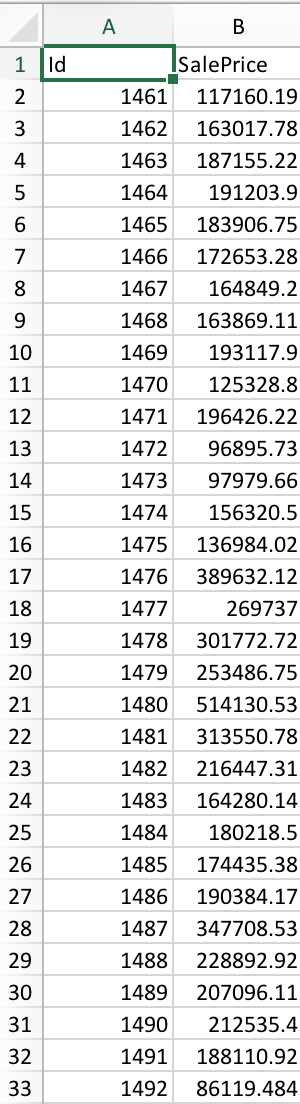

In [257]:
from IPython.display import Image
Image(filename="final.png", width=200, height = 600)

The XGBoost model made predictions for each entry in the test set. My model is scored in the 13th percentile of over 5000 entries. To further improve this model I'm going to try ensamble learning.